# 🎲 Board Games Analysis Project 🎲
----

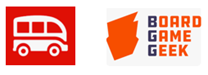

#### 🚀 Authors : Maxence Dauphin, Bernhard Riemer, Mónica Costa, Tahar Guenfoud, Konstantin Shapovalov
#### 🎯 Batch #1835 Data Science Flex



# Importing Libraries
------

In [1]:
import os
import subprocess
import re

import numpy as np
import pandas as pd
pd.options.display.max_columns = None

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn import set_config; set_config(display="diagram")
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from xgboost import XGBRegressor

# Load data from Kaggle
---

In [2]:
# Define the path to raw_data repo
raw_data_path = "~/code/maxencedauphin/bgg-project/raw_data"
raw_data_path = os.path.expanduser(raw_data_path)

# Define the url to Kaggle data
kaggle_data_path = "https://www.kaggle.com/api/v1/datasets/download/melissamonfared/board-games"

# Define the archive path
archive_path = os.path.join(raw_data_path, "archive.zip")

# Check if the archive exists
if os.path.exists(archive_path):
    try:
        print("Archive exists. Please enter 'yes' to reload data or 'no' to keep existing data.")
        user_input = input("Enter your choice (yes/no): ")

        if user_input.lower() == "yes":
            subprocess.run(f"curl -L -o {archive_path} {kaggle_data_path}", shell=True)
            subprocess.run(f"unzip -o {archive_path} -d {raw_data_path}", shell=True)
        else:
            print("Keeping existing data.")
    except EOFError:
        print("User input not supported in this environment. Proceeding with default action.")
        print("Keeping existing data.")
else:
    subprocess.run(f"curl -L -o {archive_path} {kaggle_data_path}", shell=True)
    subprocess.run(f"unzip {archive_path} -d {raw_data_path}", shell=True)

Archive exists. Please enter 'yes' to reload data or 'no' to keep existing data.
Keeping existing data.


In [3]:
filepath = "~/code/maxencedauphin/bgg-project/raw_data/BGG_Data_Set.csv"
df_orig = pd.read_csv(filepath, encoding='ISO-8859-1')
df = df_orig.copy()

# EDA
---

In [4]:
df.head(2)

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430.0,Gloomhaven,2017.0,1,4,120,14,42055,8.79,1,3.86,68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936.0,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,8.61,2,2.84,65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"


In [5]:
rows, col = df.shape
print(f"Total rows : {rows}, Total columns : {col}")

Total rows : 20343, Total columns : 14


In [6]:
# DUPLICATES
df.duplicated().sum()

np.int64(0)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20343 entries, 0 to 20342
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  20327 non-null  float64
 1   Name                20343 non-null  object 
 2   Year Published      20342 non-null  float64
 3   Min Players         20343 non-null  int64  
 4   Max Players         20343 non-null  int64  
 5   Play Time           20343 non-null  int64  
 6   Min Age             20343 non-null  int64  
 7   Users Rated         20343 non-null  int64  
 8   Rating Average      20343 non-null  float64
 9   BGG Rank            20343 non-null  int64  
 10  Complexity Average  20343 non-null  float64
 11  Owned Users         20320 non-null  float64
 12  Mechanics           18745 non-null  object 
 13  Domains             10184 non-null  object 
dtypes: float64(5), int64(6), object(3)
memory usage: 2.2+ MB


In [8]:
df.dtypes.value_counts()

int64      6
float64    5
object     3
Name: count, dtype: int64

In [9]:
df.select_dtypes(include=["object"]).nunique().sort_values(ascending=False)

Name         19974
Mechanics     7381
Domains         39
dtype: int64

In [10]:
df.select_dtypes(include=["float64"]).nunique().sort_values(ascending=False)

ID                    20327
Owned Users            3997
Rating Average          622
Complexity Average      379
Year Published          188
dtype: int64

In [11]:
df.select_dtypes(include=["int64"]).nunique().sort_values(ascending=False)

BGG Rank       20343
Users Rated     2973
Play Time        116
Max Players       54
Min Age           21
Min Players       11
dtype: int64

In [12]:
df.describe()

,ID,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users
count,20327.000000,20342.000000,20343.000000,20343.000000,20343.000000,20343.000000,20343.000000,20343.000000,20343.000000,20343.000000,20320.000000
mean,108216.245142,1984.249877,2.019712,5.672221,91.294548,9.601485,840.971391,6.403227,10172.890429,1.991188,1408.457628
std,98682.097298,214.003181,0.690366,15.231376,545.447203,3.645458,3511.562220,0.935911,5872.831597,0.848903,5040.179315
min,1.000000,-3500.000000,0.000000,0.000000,0.000000,0.000000,30.000000,1.050000,1.000000,0.000000,0.000000
25%,11029.000000,2001.000000,2.000000,4.000000,30.000000,8.000000,55.000000,5.820000,5087.500000,1.330000,146.000000
50%,88931.000000,2011.000000,2.000000,4.000000,45.000000,10.000000,120.000000,6.430000,10173.000000,1.970000,309.000000
75%,192939.500000,2016.000000,2.000000,6.000000,90.000000,12.000000,385.000000,7.030000,15258.500000,2.540000,864.000000
max,331787.000000,2022.000000,10.000000,999.000000,60000.000000,25.000000,102214.000000,9.580000,20344.000000,5.000000,155312.000000


#### 🤔 My reflections:

- convert column names to lowercase and replace spaces with underscores to facilitate using pandas df.name syntax
- remove the game ID column as it does not provide inherent information about the game's quality or rating
- remove rows where the value for owned_users is NaN
- replace missing values in the mechanics and domains columns with "unspecified"
- rework mechanics and domains columns which contains a list of strings
- we have numerous categorical values to encode: 19,974 for name, 7,379 for mechanics, and 40 for domains. To maintain a simple basic model, I removed the name column

TODO
- we need to rework the year_published column to handle NaN, 0, and negative values, which represent very old games dated "BC"
- we need to transform the list values in mechanics and domains into something more meaningful
- ...


#### 🛍️ Convert column names to lowercase and replace spaces with underscores to facilitate using pandas df.name syntax

In [13]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Output the transformed column names
print(df.columns)

Index(['id', 'name', 'year_published', 'min_players', 'max_players',
       'play_time', 'min_age', 'users_rated', 'rating_average', 'bgg_rank',
       'complexity_average', 'owned_users', 'mechanics', 'domains'],
      dtype='object')


#### 🛍️ Remove the game ID column as it does not provide inherent information about the game's quality or rating

In [14]:
rows, col = df.shape
print(f"Total rows : {rows}, Total columns : {col}")

Total rows : 20343, Total columns : 14


In [15]:
df.drop(columns=['id'], inplace=True)

In [16]:
rows, col = df.shape
print(f"Total rows : {rows}, Total columns : {col}")

Total rows : 20343, Total columns : 13


#### 🛍️ Remove rows where the value for owned_users is NaN

In [17]:
df = df[df['owned_users'].notna()]

In [18]:
rows, col = df.shape
print(f"Total rows : {rows}, Total columns : {col}")

Total rows : 20320, Total columns : 13


#### 🛍️ Replace missing values in the mechanics and domains columns with "unspecified"

In [19]:
print("Columns with missing values:", df.columns[df.isnull().any()])

Columns with missing values: Index(['mechanics', 'domains'], dtype='object')


In [20]:
df["mechanics"] = df["mechanics"].fillna("unspecified")
df["domains"] = df["domains"].fillna("unspecified")

In [21]:
print("Columns with missing values:", df.columns[df.isnull().any()])

Columns with missing values: Index([], dtype='object')


#### 🛍️ Rework mechanics and domains columns which contains a list of strings

In [22]:
def clean(text):
    cln = re.sub('[^a-zA-Z], ,', ' ', str(text))
    cln = cln.replace("/",",")
    cln = cln.split()
    cln = ' '.join(cln)
    return cln
df["mechanics"] = df["mechanics"].apply(clean)
df["domains"] = df["domains"].apply(clean)

#### 🛍️ Transform 'year_published' column to datetime type -> TODO

In [23]:
#df['year_published'].dtype

In [24]:
df['year_published'].nunique()

188

In [25]:
# TODO
# negative_zero_nan_rows = df[(df['year_published'] <= 0) | df['year_published'].isna()]

# BASELINE
---

In [26]:
df_clean = df.copy()

In [27]:
# we have numerous categorical values to encode: 19,974 for name, 7,379 for mechanics, and 40 for domains. To maintain a simple basic model, I removed the name column
df_clean.drop(columns=['name'], inplace=True)
df_clean.columns

Index(['year_published', 'min_players', 'max_players', 'play_time', 'min_age',
       'users_rated', 'rating_average', 'bgg_rank', 'complexity_average',
       'owned_users', 'mechanics', 'domains'],
      dtype='object')

In [28]:
# Split data into features (X) and target (y)
# We want to predict Average Ratings
X = df_clean.drop('rating_average', axis=1)
y = df_clean['rating_average']

In [29]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16256, 11), (4064, 11), (16256,), (4064,))

#### categorical features

In [31]:
df_clean.select_dtypes(include=["object"]).nunique().sort_values(ascending=False)

mechanics    7379
domains        40
dtype: int64

In [32]:
categorical_features_unique = df_clean.select_dtypes(include=["object"]).nunique()
categorical_features_unique.sum()

np.int64(7419)

In [33]:
preproc_categorical_baseline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse_output=False)
)

preproc_categorical_baseline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                               sparse_output=False))])

#### numerical features

In [34]:
preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    MinMaxScaler()
)

preproc_numerical_baseline

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('minmaxscaler', MinMaxScaler())])

In [35]:
preproc_baseline = ColumnTransformer([
    ("num_transform", preproc_numerical_baseline, make_column_selector(dtype_include=np.number)),
    ("cat_transform", preproc_categorical_baseline, make_column_selector(dtype_exclude=np.number))
]).set_output(transform="pandas")

In [36]:
pipeline_baseline = make_pipeline(preproc_baseline, DecisionTreeRegressor())
pipeline_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe8c256f490>),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe8c256d420>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [37]:
cv_score = cross_val_score(pipeline_baseline, X_train, y_train, cv=5).mean()
print(f"Cross-validation score: {cv_score}")

Cross-validation score: 0.8832709302683913


In [38]:
#pipeline_baseline.get_params()

In [39]:
pipeline_baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe8c256f490>),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe8c256d420>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [40]:
# Make predictions
y_pred = pipeline_baseline.predict(X_test)

Evaluate the model on the test set

In [41]:
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

MAE: 0.17947588582677168, MSE: 0.09529343011811023, RMSE: 0.308696339657778


In [43]:
import pickle
models_path = os.path.expanduser("~/code/maxencedauphin/bgg-project/models")
pickle_file_path = os.path.join(models_path, "pipeline_baseline.pkl")

if not os.path.exists(models_path):
        os.makedirs(models_path)
# Export Pipeline as pickle file
with open(pickle_file_path, "wb") as file:
    pickle.dump(pipeline_baseline, file)

print(f"Model saved to: {pickle_file_path}")

Model saved to: /home/maxd/code/maxencedauphin/bgg-project/models/pipeline_baseline.pkl
